# Imdb sentiment analysis
Sentiment analysis on the Imdb dataset using bag of words FCN model (unigrams) and a vanilla RNN model. The FCN outperforms the RNN with a test accuracy of 87% compared with 85%.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import re
from collections import defaultdict
from tqdm.notebook import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from utils import train, accuracy, count_parameters, plot_loss_acc
import matplotlib.pyplot as plt

In [3]:
PATH = Path.cwd() / "data" / "Imdb"
TRAIN_PATH = PATH / "train"
TEST_PATH = PATH / "test"

In [4]:
TEST_PATH

WindowsPath('C:/Stuff/py/projects/ml/ml/data/Imdb/test')

In [5]:
def create_path_list(path):
    pos_reviews = [f for f in (path / "pos").iterdir()]
    neg_reviews = [f for f in (path / "neg").iterdir()]
    return {"pos": pos_reviews, "neg": neg_reviews}

In [6]:
train_paths = create_path_list(TRAIN_PATH)
test_paths = create_path_list(TEST_PATH)

In [7]:
def load_review(path):
    with open(path, "r", encoding="utf-8") as f:
        text = f.read()
        text = text.lower()
        text = re.sub("<[\w\s]*\/*>", " ", text) # remove tags
        text = re.sub('[^A-Za-z ]+', '', text) # remove symbols 
        return text.split()

In [8]:
def get_word_counts():
    review_paths = create_path_list(TRAIN_PATH)
    all_paths = review_paths["pos"] + review_paths["neg"]
    all_words = defaultdict(int)
    for path in tqdm(all_paths):
        try:
            words = load_review(path)
            for word in words:
                all_words[word] = all_words[word] + 1
        except Exception as e:
            print(path)
    return all_words

In [9]:
all_words = get_word_counts()

In [10]:
def sort_words(word_dict):
    occurance = np.array([v for v in word_dict.values()])
    sorted_idx = np.argsort(occurance)[::-1]
    words = [k for k in word_dict.keys()]
    sorted_words = [(words[idx], occurance[idx]) for idx in sorted_idx]
    return sorted_words

In [11]:
sw = sort_words(all_words)

In [12]:
VOCAB_SIZE = 5000
top_words = [word for word, count in sw[:VOCAB_SIZE]]
vocab = {word: i for i, word in enumerate(top_words)}
vocab["a"], vocab["the"]

(2, 0)

In [13]:
def get_word_frequency(vocab, path):
    X = torch.zeros(len(vocab))
    words = load_review(path)
    for word in words:
        if word in vocab:
            idx = vocab[word]
            X[idx] += 1
    return X

In [14]:
def create_freq_dataset(vocab, paths):
    pos_size = len(paths["pos"])
    total_size =  pos_size+ len(paths["neg"])
    y = torch.zeros(total_size, dtype=torch.long)
    y[:pos_size] = 1
    X = torch.zeros((total_size, len(vocab)))
    i = 0
    for key in ("pos", "neg"):
        for p in paths[key]:
            X[i] = get_word_frequency(vocab, p)
            i += 1
    return X, y

In [15]:
X_train, y_train = create_freq_dataset(vocab, train_paths)
X_test, y_test = create_freq_dataset(vocab, test_paths)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([25000, 5000]),
 torch.Size([25000, 5000]),
 torch.Size([25000]),
 torch.Size([25000]))

In [17]:
train_dataset = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_dataset = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=True)

In [19]:
freq_model = nn.Sequential(nn.Linear(VOCAB_SIZE, 8), nn.ReLU(), nn.Linear(8, 2))
crit = nn.CrossEntropyLoss()
opt = optim.Adam(freq_model.parameters(), lr=0.001, weight_decay=0.001)

In [20]:
count_parameters(freq_model, True)

+----------+------------+
| Modules  | Parameters |
+----------+------------+
| 0.weight |   40000    |
|  0.bias  |     8      |
| 2.weight |     16     |
|  2.bias  |     2      |
+----------+------------+
Total Trainable Params: 40026


40026

In [21]:
train_loss, train_acc, test_loss, test_acc = train(freq_model, crit, opt, train_dataset, test_dataset, accuracy, n_epochs=10)


Epoch:1, T Loss:0.378, T Met:0.846, V Loss:0.298, V Met:0.884



Epoch:2, T Loss:0.258, T Met:0.901, V Loss:0.297, V Met:0.882



Epoch:3, T Loss:0.234, T Met:0.912, V Loss:0.306, V Met:0.879



Epoch:4, T Loss:0.223, T Met:0.915, V Loss:0.321, V Met:0.873



Epoch:5, T Loss:0.216, T Met:0.918, V Loss:0.334, V Met:0.872



Epoch:6, T Loss:0.213, T Met:0.917, V Loss:0.331, V Met:0.872



Epoch:7, T Loss:0.211, T Met:0.919, V Loss:0.348, V Met:0.867



Epoch:8, T Loss:0.207, T Met:0.919, V Loss:0.340, V Met:0.870



Epoch:9, T Loss:0.205, T Met:0.920, V Loss:0.359, V Met:0.864



Epoch:10, T Loss:0.203, T Met:0.921, V Loss:0.356, V Met:0.867


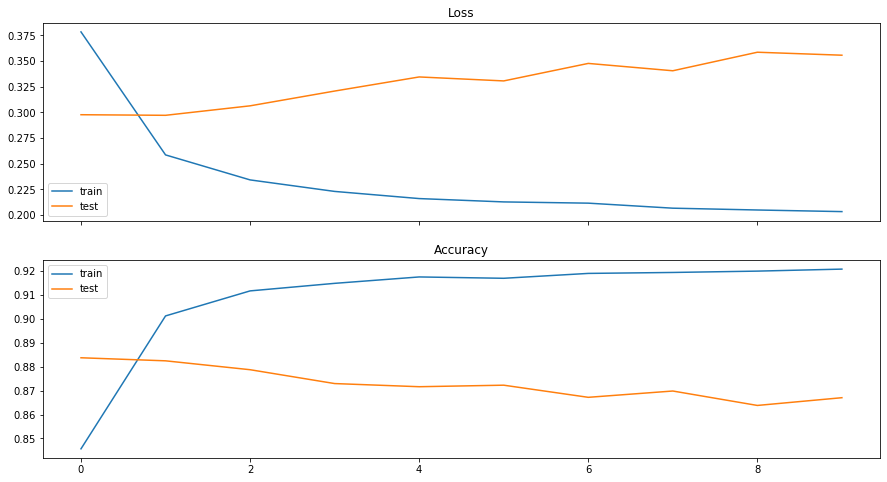

In [22]:
plot_loss_acc(train_loss, train_acc, test_loss, test_acc)

In [23]:
def check_dataset_sizes(paths):
    sizes = []
    for key in ("pos", "neg"):
        for p in paths[key]:
            sizes.append(len(load_review(p)))
    return sizes

In [24]:
s = check_dataset_sizes(train_paths)

In [25]:
s = np.array(s)
print(s.min(), s.max(), s.mean())
for i in range(100, 2600, 200):
    print(f" % samples < {i} -  {(s < i).sum()/len(s)}")

10 2450 229.43412
 % samples < 100 -  0.12384
 % samples < 300 -  0.77784
 % samples < 500 -  0.92276
 % samples < 700 -  0.97116
 % samples < 900 -  0.99
 % samples < 1100 -  0.9992
 % samples < 1300 -  0.99952
 % samples < 1500 -  0.9998
 % samples < 1700 -  0.99984
 % samples < 1900 -  0.99996
 % samples < 2100 -  0.99996
 % samples < 2300 -  0.99996
 % samples < 2500 -  1.0


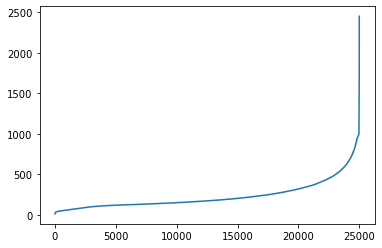

In [26]:
plt.plot(np.sort(s))
plt.show()

In [27]:
def get_seq_dataset(vocab, paths, max_size):
    pos_size = len(paths["pos"])
    total_size =  pos_size+ len(paths["neg"])
    y = torch.zeros(total_size, dtype=torch.long)
    y[:pos_size] = 1
    X = torch.zeros((total_size, max_size), dtype=torch.long)
    i = 0
    sizes = torch.zeros(total_size)
    for key in ("pos", "neg"):
        for p in paths[key]:
            encoding, size = get_word_encoding(vocab, p, max_size)
            X[i] = encoding
            sizes[i] = size
            i += 1
    return X, y, sizes 

In [28]:
def get_word_encoding(vocab, path, max_size):
    words = load_review(path)
    size = min(len(words), max_size)
    X = torch.ones(max_size, dtype=torch.long) * len(vocab) + 1
    for i, word in enumerate(words):
        if i >= max_size:
            break
        if word in vocab:
            enc = vocab[word]
        else:
            enc = len(vocab)
        X[i] = enc
    return X, size

In [29]:
MAX_SIZE = 1000
X_train_rnn, y_train_rnn, train_sizes = get_seq_dataset(vocab, train_paths, MAX_SIZE)
X_test_rnn, y_test_rnn, test_sizes = get_seq_dataset(vocab, test_paths, MAX_SIZE)

In [30]:
class VariableIter:
    def __init__(self, X, y, sizes, batch_size=None):
        sizes, indices = torch.sort(sizes)
        self.X = X[indices]
        self.y = y[indices]
        self.batch_size = batch_size
        if self.batch_size:
            self.batch_slices = self.get_padded_batches(sizes, batch_size)
        else:
            self.batch_slices = self.get_batches(sizes)
            
    def get_padded_batches(self, sizes, batch_size):
        batch_sizes = []
        for i in range(0, len(sizes), batch_size):
            end = min(i + batch_size, len(sizes))
            batch_sizes.append((i, end, int(sizes[end - 1].item())))
        return batch_sizes
    
    def get_batches(self, sizes):
        unique_sizes = torch.unique(sizes)
        count = 0
        start = 0
        batch_sizes = []
        for size in unique_sizes:
            n_samples = (sizes == size).sum().item()
            end = start + n_samples
            batch_sizes.append((start, end, int(size.item())))
            start = end
        return batch_sizes
            
        
    def __len__(self):
        return len(self.batch_slices)
    
    def __iter__(self):
        for row_start, row_end, size in self.batch_slices:
            yield self.X[row_start:row_end, :size], self.y[row_start:row_end]

In [31]:
train_ds = VariableIter(X_train_rnn, y_train_rnn, train_sizes, batch_size=64)
test_ds = VariableIter(X_test_rnn, y_test_rnn, test_sizes, batch_size=64)

In [32]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.em = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)
        
    def forward(self, x):
        x = self.em(x)
        o, h = self.rnn(x)
        return self.fc(h.squeeze(0))

In [33]:
rnn_model = RNN(VOCAB_SIZE + 2, 16, 16)
crit = nn.CrossEntropyLoss()
opt = optim.Adam(rnn_model.parameters(), lr=0.001, weight_decay=0.0001)

In [34]:
count_parameters(rnn_model, True)

+------------------+------------+
|     Modules      | Parameters |
+------------------+------------+
|    em.weight     |   80032    |
| rnn.weight_ih_l0 |    256     |
| rnn.weight_hh_l0 |    256     |
|  rnn.bias_ih_l0  |     16     |
|  rnn.bias_hh_l0  |     16     |
|    fc.weight     |     32     |
|     fc.bias      |     2      |
+------------------+------------+
Total Trainable Params: 80610


80610

In [35]:
train_loss, train_acc, test_loss, test_acc = train(rnn_model, crit, opt, train_ds, val=test_ds, metric=accuracy, clip=1.0, n_epochs=30)


Epoch:1, T Loss:0.693, T Met:0.520, V Loss:0.692, V Met:0.520



Epoch:2, T Loss:0.680, T Met:0.565, V Loss:0.646, V Met:0.630



Epoch:3, T Loss:0.615, T Met:0.672, V Loss:0.605, V Met:0.681



Epoch:4, T Loss:0.551, T Met:0.732, V Loss:0.532, V Met:0.747



Epoch:5, T Loss:0.499, T Met:0.771, V Loss:0.497, V Met:0.773



Epoch:6, T Loss:0.452, T Met:0.803, V Loss:0.465, V Met:0.794



Epoch:7, T Loss:0.419, T Met:0.822, V Loss:0.429, V Met:0.816



Epoch:8, T Loss:0.396, T Met:0.835, V Loss:0.421, V Met:0.820



Epoch:9, T Loss:0.387, T Met:0.841, V Loss:0.421, V Met:0.816



Epoch:10, T Loss:0.371, T Met:0.850, V Loss:0.428, V Met:0.819



Epoch:11, T Loss:0.357, T Met:0.858, V Loss:0.496, V Met:0.776



Epoch:12, T Loss:0.352, T Met:0.860, V Loss:0.381, V Met:0.847



Epoch:13, T Loss:0.338, T Met:0.866, V Loss:0.429, V Met:0.828



Epoch:14, T Loss:0.326, T Met:0.871, V Loss:0.365, V Met:0.847



Epoch:15, T Loss:0.334, T Met:0.869, V Loss:0.355, V Met:0.852



Epoch:16, T Loss:0.317, T Met:0.876, V Loss:0.364, V Met:0.855



Epoch:17, T Loss:0.327, T Met:0.873, V Loss:0.351, V Met:0.853



Epoch:18, T Loss:0.345, T Met:0.864, V Loss:0.492, V Met:0.765



Epoch:19, T Loss:0.333, T Met:0.868, V Loss:0.394, V Met:0.845



Epoch:20, T Loss:0.326, T Met:0.872, V Loss:0.371, V Met:0.849



Epoch:21, T Loss:0.324, T Met:0.871, V Loss:0.390, V Met:0.830



Epoch:22, T Loss:0.326, T Met:0.872, V Loss:0.370, V Met:0.841



Epoch:23, T Loss:0.321, T Met:0.874, V Loss:0.346, V Met:0.859



Epoch:24, T Loss:0.325, T Met:0.871, V Loss:0.461, V Met:0.822



Epoch:25, T Loss:0.338, T Met:0.866, V Loss:0.397, V Met:0.840



Epoch:26, T Loss:0.321, T Met:0.877, V Loss:0.456, V Met:0.832



Epoch:27, T Loss:0.320, T Met:0.873, V Loss:0.375, V Met:0.854



Epoch:28, T Loss:0.329, T Met:0.870, V Loss:0.417, V Met:0.834



Epoch:29, T Loss:0.309, T Met:0.879, V Loss:0.386, V Met:0.844



Epoch:30, T Loss:0.343, T Met:0.866, V Loss:0.426, V Met:0.838


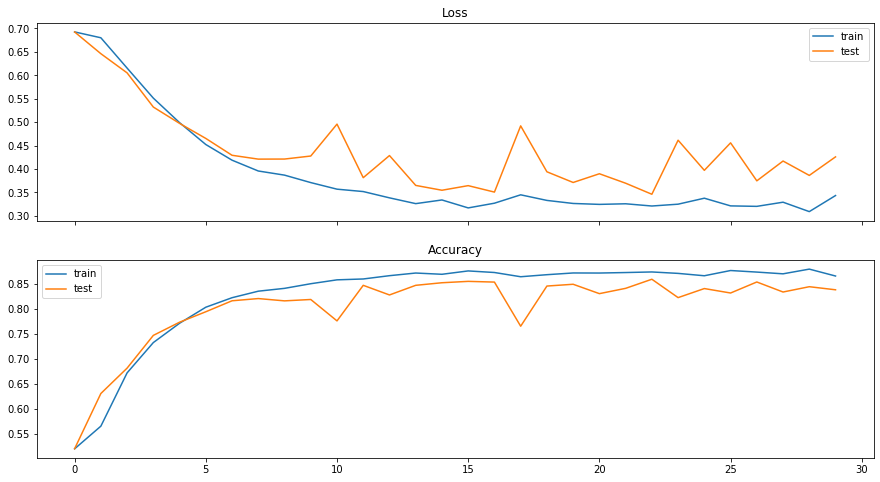

In [36]:
plot_loss_acc(train_loss, train_acc, test_loss, test_acc)